# Project overview
This project aims to use nn regression to figure out how input features influence output feature and reflect dependence of output on input

## Data base
All the data were generated by MATLAB simulation. Each row is a node and columns are the features on such node, for example, $A_{1,1}$ is Mesh label 1 of first node of mesh file 1.
Every 100 row mean one specific mesh file, for example, rows $1-100$ mean mesh file 1, rows $101-200$ mean mesh file 2.etc. Frist 5 colomns are mesh labels.

Here's all the data features:

<table>
  <tr>
    <th>Col 1</th>
    <th>Col 2</th>
    <th>Col 3</th>
    <th>Col 4</th>
    <th>Col 5</th>
    <th>Col 6</th>
    <th>Col 7</th>
    <th>Col 8</th>
    <th>Col 9</th>
    <th>Col 10</th>
  </tr>
  <tr>
    <td>Diameter</td>
    <td>w_ip</td>
    <td>w_p</td>
    <td>amplitute</td>
    <td>ip_hight</td>
    <td>distance</td>
    <td>conduct_center</td>
    <td>conduct_around</td>
    <td>conduct_bulk</td>
    <td>Na_area</td>
  </tr>
  <tr>
    <th>Col 11</th>
    <th>Col 12</th>
    <th>Col 13</th>
    <th>Col 14</th>
    <th>Col 15</th>
    <th>Col 16</th>
    <th>Col 17</th>
    <th>Col 18</th>
    <th>Col 19</th>
    <th>Col 20</th>
  </tr>
  <tr>
    <td>Kir_area</td>
    <td>NKA_area</td>
    <td>phi_cleft</td>
    <td>Na_pre</td>
    <td>Na_post</td>
    <td>S_Na</td>
    <td>S_K</td>
    <td>S_Ca</td>
    <td>S_A</td>
    <td>CV</td>
  </tr>
</table>

We are using 134 meshes here so will be $13400\times 20$ matrix

## Methods

We are using feedforward nn for regression and track gradience backward to get dependence. Here's the neuron number table
|Input| First layer|Second Layer| Output|
|-----------|-----------|-----------|-----------|
|M|256|128|1|



Import library

In [9]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Fix radom seed to make sure stability of our regression

In [10]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42) 

In [11]:
def visualize_feature_influence(gradient_matrix, input_names, output_names, title="Gradient Heatmap"):
    """
    Visualizes the influence of input features on output features using a heatmap.

    This function plots a heatmap where each cell represents the gradient of 
    a specific input feature with respect to a specific output feature.

    Parameters:
    - gradient_matrix (torch.Tensor): A PyTorch tensor containing gradient values.
    - input_names (list): List of input feature names for labeling the y-axis.
    - output_names (list): List of output feature names for labeling the x-axis.
    - title (str, optional): Title of the heatmap. Default is "Gradient Heatmap".

    Returns:
    - None (Displays the heatmap directly)
    """

    # Convert the gradient matrix from PyTorch tensor to NumPy array
    grad_matrix_np = gradient_matrix.cpu().numpy()

    # Compute the absolute maximum value in the matrix
    # This is used to dynamically set the color scale for better visualization
    abs_max = np.max(np.abs(grad_matrix_np))  

    # Create a larger figure size to improve readability
    plt.figure(figsize=(8, 6))

    # Plot the heatmap
    sns.heatmap(
        grad_matrix_np, 
        cmap="coolwarm",            # "coolwarm" colormap for better visualization of positive/negative values
        annot=True,                 # Display numerical values in each cell
        fmt=".2e",                  # Display values in scientific notation for clarity
        xticklabels=output_names,   # Set x-axis labels
        yticklabels=input_names,    # Set y-axis labels
        vmin=-abs_max,              # Set color scale minimum to -|max value|
        vmax=abs_max,               # Set color scale maximum to +|max value|
        center=0                    # Center the color map at zero to emphasize positive/negative influence
    )

    # Add labels and title
    plt.title(title)
    plt.xlabel("Output Features")
    plt.ylabel("Input Features")
    
    # Display the heatmap
    plt.show()

Define gradient track function

In [12]:
def analyze_feature_influence(model, sample_input):
    """
    Analyzes the influence of each input feature on the model's output
    using gradient-based analysis.

    Parameters:
    - model: The neural network model for which feature influence is analyzed.
    - sample_input: A sample input tensor to compute gradients with respect to.

    Returns:
    - gradient_matrix: A tensor containing the average gradient values
                       for each input feature with respect to each output feature.
    """
    sample_input.requires_grad = True  # Enable gradient tracking for the input
    output = model(sample_input)       # Forward pass to compute model output
    num_inputs = sample_input.size(1)  # Number of input features
    num_outputs = output.size(1)       # Number of output features
    gradient_matrix = torch.zeros(num_inputs, num_outputs)  # Initialize gradient matrix

    # Compute gradient for each output feature with respect to all input features
    for i in range(num_outputs):
        model.zero_grad()             # Zero out gradients before each iteration
        sample_input.grad = None      # Clear existing gradients to avoid accumulation
        # Compute the gradient of the mean of the i-th output feature
        output[:, i].mean().backward(retain_graph=True)
        # Store the mean gradient for each input feature
        gradient_matrix[:, i] = sample_input.grad.mean(dim=0)

    return gradient_matrix


Set NN class

In [13]:
class RegressionNN(nn.Module):
    """
    A simple feedforward neural network for regression tasks.

    Architecture:
    - Input Layer: Linear layer with `input_dim` neurons
    - Hidden Layer 1: 256 neurons with ReLU activation and optional Dropout
    - Hidden Layer 2: 128 neurons with ReLU activation and optional Dropout
    - Output Layer: Linear layer with `output_dim` neurons (for regression output)

    Dropout is initially set to 0.0 (disabled), but can be adjusted if needed.
    """

    def __init__(self, input_dim, output_dim):
        """
        Initializes the network layers.

        Parameters:
        - input_dim (int): Number of input features.
        - output_dim (int): Number of output values (e.g., for multi-output regression).
        """
        super(RegressionNN, self).__init__()

        # Fully connected layers (Linear layers)
        self.fc1 = nn.Linear(input_dim, 128 * 2)  # First hidden layer with 256 neurons
        self.fc2 = nn.Linear(128 * 2, 64 * 2)      # Second hidden layer with 128 neurons
        self.fc3 = nn.Linear(64 * 2, output_dim)   # Output layer

        # Activation function
        self.relu = nn.ReLU()

        # Dropout layer (currently disabled; set to 0.0)
        # To introduce slight regularization, set this to 0.1 or 0.2
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        """
        Forward pass logic for the network.

        Parameters:
        - x (torch.Tensor): Input tensor with shape (batch_size, input_dim).

        Returns:
        - Output tensor with shape (batch_size, output_dim).
        """
        x = self.relu(self.fc1(x))   # First layer + ReLU
        x = self.dropout(x)          # Dropout (currently inactive)
        x = self.relu(self.fc2(x))   # Second layer + ReLU
        x = self.fc3(x)              # Output layer (no activation for regression)
        return x

Load data

In [ ]:
# model_type = "Mdisc"
model_type = "CV"

match model_type:
    case "Mdisc":
        file_path = r'D:\codes\matlab code\Save_data\All_mesh_data\ORd11_1D Mdisc cleft EpC_cell_num_20_all_mesh_norm_data.csv'
    case "ID":
        file_path = r'D:\codes\matlab code\Save_data\All_mesh_data\ORd11_1D Mdisc cleft ID EpC_cell_num_20_all_mesh_norm_data.csv'
    case "CV":
        file_path = r'D:\codes\matlab code\Save_data\All_mesh_data\ORd11_1D Mdisc cleft ID EpC_cell_num_20_allMesh_global_parameters_norm_data.csv'
    case _:
        raise ValueError(f"Unknown model type: {model_type}")

print(f"Model type: {model_type}")

df = pd.read_csv(file_path)

X_all = df.iloc[:, 0:5].values # Input 
Y_all = df.iloc[:, -1].values.reshape(-1,1) # Output

X_tensor = torch.tensor(X_all, dtype=torch.float32)
Y_tensor = torch.tensor(Y_all, dtype=torch.float32)

print(" X_all shape:", X_all.shape)
print(" Y_all shape:", Y_all.shape)
print("X_tensor shape:", X_tensor.shape)
print("Y_tensor shape:", Y_tensor.shape)

Model type: CV
 X_all shape: (341, 5)
 Y_all shape: (341, 1)
X_tensor shape: torch.Size([341, 5])
Y_tensor shape: torch.Size([341, 1])


Split data into training and testing set

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_tensor, Y_tensor, test_size=0.1, random_state=42, shuffle=True
)

print("X_train shape:", X_train.shape, "Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape, "Y_test shape:", Y_test.shape)

X_train shape: torch.Size([306, 5]) Y_train shape: torch.Size([306, 1])
X_test shape: torch.Size([35, 5]) Y_test shape: torch.Size([35, 1])


Set up training parameters

In [16]:
input_dim = X_train.size(1)
output_dim = Y_train.size(1)

criterion = nn.MSELoss()
learning_rate = 1e-3

step_size = 5
gamma = 0.5

Start training

In [17]:
epochs = 65
batch_size = 16
num_batches = len(X_train) // batch_size

All_gradient_mat = torch.zeros(input_dim, output_dim)

# Training time num_models
num_models = 3  

for model_idx in range(num_models):
    print(f"\n=== Training model {model_idx + 1}/{num_models} ===")
    NNmodel = RegressionNN(input_dim, output_dim)

    optimizer = optim.Adam(NNmodel.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    best_val_loss = float('inf') 
    patience_threshold = 100
    patience_count = 0

   
    best_model_state = None

    for epoch in range(epochs):
        NNmodel.train()
        permutation = torch.randperm(X_train.size(0))
        X_train_shuffled = X_train[permutation]
        Y_train_shuffled = Y_train[permutation]

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            x_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = Y_train_shuffled[start_idx:end_idx]

            outputs = NNmodel(x_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        scheduler.step()

        if (epoch + 1) % 5 == 0:
            NNmodel.eval()
            with torch.no_grad():
                val_outputs = NNmodel(X_test)
                val_loss = criterion(val_outputs, Y_test)

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_count = 0
                best_model_state = NNmodel.state_dict()  
            else:
                patience_count += 1

            if patience_count >= patience_threshold:
                print(f"Early stopping at epoch {epoch+1}")
                break

    if best_model_state is not None:
        NNmodel.load_state_dict(best_model_state)

    gradient_matrix = analyze_feature_influence(NNmodel, X_train)
    All_gradient_mat += gradient_matrix

All_gradient_mat /= num_models

print("\n=== Gradient Matrix ===")
print(All_gradient_mat)


=== Training model 1/3 ===
Epoch [5/65], Train Loss: 158.6340, Val Loss: 211.5420
Epoch [10/65], Train Loss: 177.8617, Val Loss: 194.5457
Epoch [15/65], Train Loss: 172.2085, Val Loss: 197.7258
Epoch [20/65], Train Loss: 132.1181, Val Loss: 186.9863
Epoch [25/65], Train Loss: 125.9385, Val Loss: 186.6723
Epoch [30/65], Train Loss: 113.6823, Val Loss: 186.9810
Epoch [35/65], Train Loss: 161.7114, Val Loss: 185.6760
Epoch [40/65], Train Loss: 132.5853, Val Loss: 185.4502
Epoch [45/65], Train Loss: 119.6190, Val Loss: 185.6030
Epoch [50/65], Train Loss: 106.6971, Val Loss: 185.6712
Epoch [55/65], Train Loss: 165.4902, Val Loss: 185.6535
Epoch [60/65], Train Loss: 113.0996, Val Loss: 185.5869
Epoch [65/65], Train Loss: 167.6379, Val Loss: 185.6065

=== Training model 2/3 ===
Epoch [5/65], Train Loss: 131.8309, Val Loss: 197.8590
Epoch [10/65], Train Loss: 159.2097, Val Loss: 195.9772
Epoch [15/65], Train Loss: 201.7413, Val Loss: 202.7115
Epoch [20/65], Train Loss: 161.4776, Val Loss: 191

Training evaluation

In [18]:
NNmodel.eval()
with torch.no_grad():
    Y_train_pred = NNmodel(X_train)
    Y_test_pred = NNmodel(X_test)

train_loss_final = criterion(Y_train_pred, Y_train).item()
test_loss_final = criterion(Y_test_pred, Y_test).item()

print(f"Final Train Loss: {train_loss_final:.4f}")
print(f"Final Test Loss:  {test_loss_final:.4f}")

Final Train Loss: 128.2676
Final Test Loss:  183.3651


Plot results

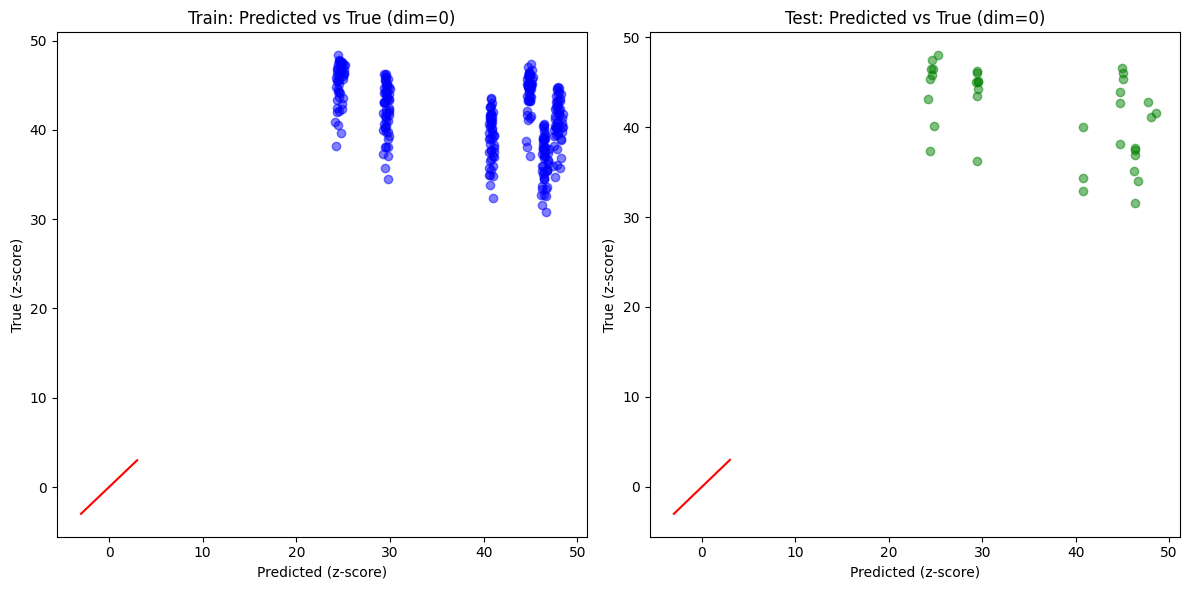

In [19]:
plt.figure(figsize=(12, 6))
# Training
plt.subplot(1, 2, 1)
plt.scatter(Y_train_pred[:, 0].cpu().numpy(), Y_train[:, 0].cpu().numpy(), color='blue', alpha=0.5)
plt.plot([-3,3], [-3,3], color='red')  
plt.title("Train: Predicted vs True (dim=0)")
plt.xlabel("Predicted (z-score)")
plt.ylabel("True (z-score)")

# Testing
plt.subplot(1, 2, 2)
plt.scatter(Y_test_pred[:, 0].cpu().numpy(), Y_test[:, 0].cpu().numpy(), color='green', alpha=0.5)
plt.plot([-3,3], [-3,3], color='red')
plt.title("Test: Predicted vs True (dim=0)")
plt.xlabel("Predicted (z-score)")
plt.ylabel("True (z-score)")

plt.tight_layout()
plt.show()

Running script main function

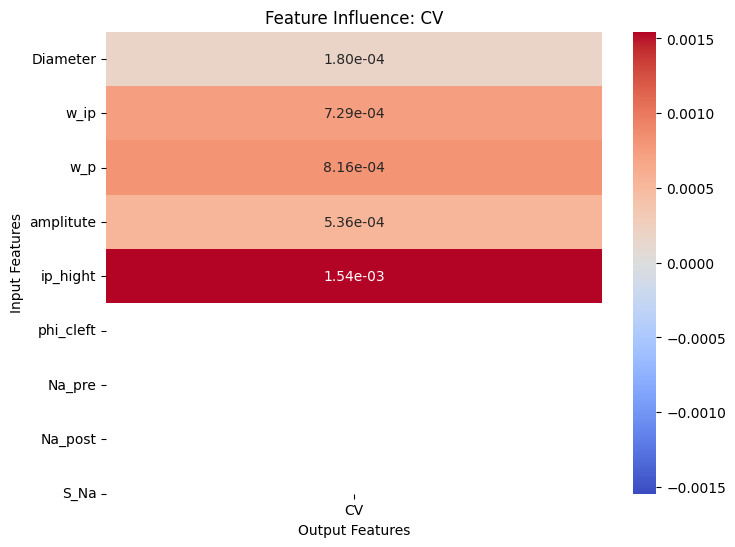

In [20]:
input_name_list = df.columns[0:9].tolist()     # ["distance", "conduct_center", "conduct_around", "conduct_bulk"] ...
output_name_list = [df.columns[12]]  # ["phi_cleft", "Na_pre", "Na_post"] ...

visualize_feature_influence(All_gradient_mat, input_name_list, output_name_list, f"Feature Influence: {model_type}")